In [1]:
import json

task = ['train', 'public']
data = {}

for t in task:
    with open(f'./data/{t}.jsonl', 'r') as json_file:
        json_list = list(json_file)
        data[t] = [json.loads(json_str) for json_str in json_list]
        print(len(data[t]))

21710
5494


In [2]:
data['train'][0]['title'][:10], data['train'][0]['maintext'][:100]

('榜首進台大醫科卻休學',
 '從小就很會念書的李悅寧， 在眾人殷殷期盼下，以榜首之姿進入臺大醫學院， 但始終忘不了對天文的熱情。大學四年級一場遠行後，她決心遠赴法國攻讀天文博士。 從小沒想過當老師的她，再度跌破眾人眼鏡返台任教， ')

## Preprocessing the data

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

2022-05-11 21:25:37.297742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 21:25:37.297766: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from torch.utils.data import Dataset, DataLoader

max_length = 384

def preprocess(articles):
    encode_articles = {}

    maintext = [article["maintext"] for article in articles]
    
    # Tokenize
    encode_articles = tokenizer(maintext, 
                                max_length=max_length,
                                truncation=True, 
                                padding=True)
    
    if 'title' in articles[0].keys():
        titles = [article["title"] for article in articles]
        encode_articles['title'] = tokenizer(titles, 
                                            max_length=56,
                                            truncation=False, 
                                            padding=True)
    return encode_articles

In [5]:
examples = data["train"][:5]
features = preprocess(examples)
print(len(features["input_ids"]), len(features["input_ids"][0]))

5 384


/home/ai2lab/anaconda3/envs/nlp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2279: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [6]:
idx = 3
tokenizer.decode(features["input_ids"][idx])

'嗨,歡迎回到【身體不適特輯】的下集,在這集裡,小編會繼續講自己食物中毒的故事,以及介紹各種症狀的英文喔!一起來看看小編悲慘的遭遇吧!還沒看過上集的朋友點這裡: 【身體不適特輯(上)】『食物中毒』、『昏倒』、『急診』英文怎麼說? the runs / diarrhea 拉肚子 小編昏倒就醫之後,後來就出現了「拉肚子」的症狀。大家多少應該有聽過 diarrhea,是「腹瀉」的意思,不過這是比較學術的名詞,口語一點的話可以說 have the runs、get the runs,就是俗稱的「拉肚子」囉。 My wife has had diarrhea for three days.(我老婆已經腹瀉三天了。) My family and I got the runs after dining in that posh restaurant.(我家人跟我在那間高級餐廳吃完晚餐後就開始拉肚子。) 如果要說「某東西讓某人拉肚子」,英文就可以用:something give(s) someone the runs,例如美味的布朗尼竟然讓你拉肚子,你就可以說: I can’t believe those delicious brownies gave me the runs.(不敢相信那些美味的布朗尼竟然讓我拉肚子。) feel nauseous / feel sick 想吐 除了「拉肚子」,小編還有「想吐」的症狀,可以用 feel 再加上形容詞 nauseous(感到噁心的、想嘔吐的)或是 sick(</s>'

In [7]:
encoded_datasets = {}
encoded_datasets = {t: preprocess(data[t]) for t in task}

In [8]:
for key in encoded_datasets['train'].keys():
    print(key, len(encoded_datasets['train'][key])) if key != 'title' else print(key, len(encoded_datasets['train'][key]['input_ids']))

input_ids 21710
attention_mask 21710
title 21710


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class Summary(Dataset):
    def __init__(self, encoded_dataset):
        self.encode_token = encoded_dataset["input_ids"]
        self.label = encoded_dataset["title"]['input_ids'] if "title" in encoded_dataset.keys() else None
        # self.label_mask = encoded_dataset["title"]['attention_mask'] if "title" in encoded_dataset.keys() else None
        # self.attention_mask = encoded_dataset["attention_mask"]
        
    def __getitem__(self, index):
        # print(f'self.encode_token[index] {self.encode_token[index]}')
        # print(f'self.label[index] {self.label[index]}')
        if self.label is None:
            return torch.tensor(self.encode_token[index])
        else:
            return torch.tensor(self.encode_token[index]), torch.tensor(self.label[index])

    def __len__(self):
        return len(self.encode_token)

In [10]:
train = Summary(encoded_datasets['train'])
valid = Summary(encoded_datasets['public'])

BATCH_SIZE = 32

trainloader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validloader = DataLoader(dataset=valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [11]:
next(iter(trainloader))

[tensor([[   259,  27477,  10776,  ..., 155249,   2446,      1],
         [  1612,   4565,    275,  ...,   1374,  28649,      1],
         [   259,  39059,  19510,  ...,  16332,   5507,      1],
         ...,
         [   259,  72486,  38970,  ...,    292,   1087,      1],
         [   259,  11522,  17726,  ...,    493, 189505,      1],
         [   259, 215127,  82783,  ...,  77460,  58195,      1]]),
 tensor([[   259, 217329,  32063,  ...,      0,      0,      0],
         [   259,   7216,   7216,  ...,      0,      0,      0],
         [   259,   8882,  21894,  ...,      0,      0,      0],
         ...,
         [   259,   4366,  19885,  ...,      0,      0,      0],
         [  6874,  69693,  16384,  ...,      0,      0,      0],
         [   259,  82783,  17435,  ...,      0,      0,      0]])]

## Fine-tuning the model

In [12]:
import os
import torch
from tw_rouge.tw_rouge import get_rouge

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} for training...')

/home/ai2lab/anaconda3/envs/nlp/lib/python3.9/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/home/ai2lab/anaconda3/envs/nlp/lib/python3.9/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
/home/ai2lab/anaconda3/envs/nlp/lib/python3.9/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(
2022-05-11 21:25:54.721814: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to c

Using cuda for training...


In [29]:
from tqdm import tqdm
import torch.optim as optim
import numpy as np

def compute_metrics(pred, label):
    decode_pred = [tokenizer.decode(p, skip_special_tokens=True) for p in pred]
    decode_label = [tokenizer.decode(l, skip_special_tokens=True) for l in label]
    score = get_rouge(decode_pred, decode_label, ignore_empty=True)
    print(f'{score}')
    return score

optimizer = optim.AdamW(model.parameters(), lr=1e-4) #考慮改1e-4
epochs = 30

model.to(device)
model.train()

train_loss_list = []
val_rouge_list = []
min_val_loss = np.Inf

print('Start training...')
step = 0
for epoch in range(epochs):
    loss_sum = 0
    for input_ids, labels in tqdm(trainloader):
        # print(f'input_ids.shape: {input_ids.shape}, labels.shape: {labels.shape}')
        input_ids, labels = input_ids.to(device), labels.to(device)
        logits = model(input_ids=input_ids, labels=labels)
        loss = logits.loss
        # print('loss:', loss)
        loss_sum += loss.item() 
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        step += 1
        
        if step%500 == 0:
            print('Validation...')
            model.eval()
            label_list, eval_predictions = [],[]
            with torch.no_grad():
                for input_ids, labels in validloader:
                    input_ids, labels = input_ids.to(device), labels.to(device)
                    outputs = model.generate(input_ids, num_beams=5, max_length=64)
                    eval_predictions += outputs
                    label_list+=labels
                rouge = compute_metrics(eval_predictions, label_list)
                val_rouge_list.append(rouge)
                print(f'Checkpoint {step} saved!')
                torch.save(model.state_dict(), f'./weight/checkpoint-{step}.pt')
            model.train()
            
    train_loss_list.append(loss_sum/len(trainloader))
    print('Epoch:', '%04d' % (epoch + 1), 'Training loss =', '{:.6f}'.format(loss_sum/len(trainloader)))
    torch.save(model.state_dict(), f'./weight/epoch-{epoch}.pt')

Start training...


 73%|███████▎  | 499/679 [10:27<03:46,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.18482460640207443, 'p': 0.3030215747024656, 'f': 0.21706249529309452}, 'rouge-2': {'r': 0.07306321136244681, 'p': 0.1214561617256346, 'f': 0.08539259303999552}, 'rouge-l': {'r': 0.16925304634624905, 'p': 0.27842639503467737, 'f': 0.19893617880199785}}
Checkpoint 500 saved!


100%|██████████| 679/679 [19:37<00:00,  1.73s/it]  


Epoch: 0001 Training loss = 1.778100


 47%|████▋     | 320/679 [06:43<07:32,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2041524309153112, 'p': 0.29460685096945544, 'f': 0.2292743964097717}, 'rouge-2': {'r': 0.08127951932733869, 'p': 0.117040551041208, 'f': 0.09048344446241124}, 'rouge-l': {'r': 0.18535237801815338, 'p': 0.26824866464442365, 'f': 0.20828901997209331}}
Checkpoint 1000 saved!


100%|██████████| 679/679 [20:04<00:00,  1.77s/it]    


Epoch: 0002 Training loss = 1.635781


 21%|██        | 141/679 [02:57<11:19,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2281834777567806, 'p': 0.30131337950298587, 'f': 0.24731369531183695}, 'rouge-2': {'r': 0.09154817525879903, 'p': 0.1174002644182683, 'f': 0.0976377080107422}, 'rouge-l': {'r': 0.20604872889966838, 'p': 0.2728519296223342, 'f': 0.2233849341126416}}
Checkpoint 1500 saved!


 94%|█████████▍| 641/679 [19:51<00:47,  1.26s/it]    

Validation...
{'rouge-1': {'r': 0.23310945430359675, 'p': 0.3012107514802488, 'f': 0.2509306188927176}, 'rouge-2': {'r': 0.0931158892491537, 'p': 0.11778089146927839, 'f': 0.09880101854049031}, 'rouge-l': {'r': 0.21039695757573945, 'p': 0.272663304385284, 'f': 0.22655144675826322}}
Checkpoint 2000 saved!


100%|██████████| 679/679 [26:09<00:00,  2.31s/it]   


Epoch: 0003 Training loss = 1.576754


 68%|██████▊   | 462/679 [09:43<04:33,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.23687189431772035, 'p': 0.3027820171625796, 'f': 0.2537071801980049}, 'rouge-2': {'r': 0.0954004385520196, 'p': 0.11843031793154668, 'f': 0.10057612174392898}, 'rouge-l': {'r': 0.21330699200470754, 'p': 0.27386219386553534, 'f': 0.22869166027305063}}
Checkpoint 2500 saved!


100%|██████████| 679/679 [20:39<00:00,  1.83s/it]   


Epoch: 0004 Training loss = 1.521098


 42%|████▏     | 283/679 [05:57<08:19,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.24334264585448767, 'p': 0.3040307104085123, 'f': 0.2588386267450287}, 'rouge-2': {'r': 0.09774220652697156, 'p': 0.11909069581618334, 'f': 0.10247557995654902}, 'rouge-l': {'r': 0.2186970785164482, 'p': 0.27408115677527484, 'f': 0.23273098898665004}}
Checkpoint 3000 saved!


100%|██████████| 679/679 [20:21<00:00,  1.80s/it]    


Epoch: 0005 Training loss = 1.480148


 15%|█▌        | 104/679 [02:11<12:04,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.25129134796248104, 'p': 0.30296245905245794, 'f': 0.26357269742945194}, 'rouge-2': {'r': 0.10160171406523057, 'p': 0.11964636106480002, 'f': 0.10512812032215173}, 'rouge-l': {'r': 0.2254922629629289, 'p': 0.2727519573857117, 'f': 0.23667001543833477}}
Checkpoint 3500 saved!


 89%|████████▉ | 604/679 [17:48<01:34,  1.26s/it]   

Validation...
{'rouge-1': {'r': 0.25336916699928774, 'p': 0.30573927924645644, 'f': 0.26619609579291514}, 'rouge-2': {'r': 0.10344145064522668, 'p': 0.12135264620477644, 'f': 0.107012960893834}, 'rouge-l': {'r': 0.22686594462760395, 'p': 0.27415895965878295, 'f': 0.2382994788412374}}
Checkpoint 4000 saved!


100%|██████████| 679/679 [24:27<00:00,  2.16s/it]  


Epoch: 0006 Training loss = 1.444081


 63%|██████▎   | 425/679 [08:55<05:20,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.25578920687838164, 'p': 0.30515709135862396, 'f': 0.26773439871332905}, 'rouge-2': {'r': 0.10349979828679799, 'p': 0.12011487691536177, 'f': 0.10674843235124003}, 'rouge-l': {'r': 0.22939441460212578, 'p': 0.27423023211567704, 'f': 0.24014373857541887}}
Checkpoint 4500 saved!


100%|██████████| 679/679 [19:24<00:00,  1.72s/it]  


Epoch: 0007 Training loss = 1.412436


 36%|███▌      | 246/679 [05:10<09:05,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.26391629964043106, 'p': 0.30369596308208785, 'f': 0.2716722081963064}, 'rouge-2': {'r': 0.10682568557138136, 'p': 0.1195552000265683, 'f': 0.1083769472912561}, 'rouge-l': {'r': 0.23502367579192845, 'p': 0.27132447333795384, 'f': 0.24202618156686057}}
Checkpoint 5000 saved!


100%|██████████| 679/679 [19:26<00:00,  1.72s/it]   


Epoch: 0008 Training loss = 1.383918


 10%|▉         | 67/679 [01:24<12:51,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.26120533470648116, 'p': 0.3070574960070592, 'f': 0.2720999589697223}, 'rouge-2': {'r': 0.10679907282099861, 'p': 0.12397720233852484, 'f': 0.11043651420428514}, 'rouge-l': {'r': 0.23299303406683625, 'p': 0.2743803922328259, 'f': 0.2427568093225703}}
Checkpoint 5500 saved!


 84%|████████▎ | 567/679 [17:07<02:21,  1.26s/it]  

Validation...
{'rouge-1': {'r': 0.2632549040479591, 'p': 0.3072719766131614, 'f': 0.2734909674004748}, 'rouge-2': {'r': 0.10799883760099956, 'p': 0.12354688665472198, 'f': 0.110895025741707}, 'rouge-l': {'r': 0.23537379528088379, 'p': 0.2748727551101614, 'f': 0.24440154836325578}}
Checkpoint 6000 saved!


100%|██████████| 679/679 [24:41<00:00,  2.18s/it]  


Epoch: 0009 Training loss = 1.362032


 57%|█████▋    | 388/679 [08:09<06:06,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.26911538184691897, 'p': 0.307084356344247, 'f': 0.276676810939542}, 'rouge-2': {'r': 0.10995447243892076, 'p': 0.12304154950821393, 'f': 0.11176870175182317}, 'rouge-l': {'r': 0.23977762058765625, 'p': 0.2739257596699245, 'f': 0.2464172741134379}}
Checkpoint 6500 saved!


100%|██████████| 679/679 [19:29<00:00,  1.72s/it]  


Epoch: 0010 Training loss = 1.334100


 31%|███       | 209/679 [04:23<09:52,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2697443344053386, 'p': 0.3072274370558344, 'f': 0.27711868782616367}, 'rouge-2': {'r': 0.11074225248034664, 'p': 0.12269561407863826, 'f': 0.11210203178176947}, 'rouge-l': {'r': 0.2410388965891985, 'p': 0.2750406017691442, 'f': 0.24760703380088156}}
Checkpoint 7000 saved!


100%|██████████| 679/679 [19:33<00:00,  1.73s/it]   


Epoch: 0011 Training loss = 1.310785


  4%|▍         | 30/679 [00:37<13:39,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2749438117128996, 'p': 0.30961384114283563, 'f': 0.28135611756229173}, 'rouge-2': {'r': 0.11332255041930551, 'p': 0.12426109654687326, 'f': 0.11422045405769485}, 'rouge-l': {'r': 0.24430552102902262, 'p': 0.2752415754515555, 'f': 0.2498349612951832}}
Checkpoint 7500 saved!


 78%|███████▊  | 530/679 [17:19<03:07,  1.26s/it]   

Validation...
{'rouge-1': {'r': 0.2737151182261681, 'p': 0.31278548623253577, 'f': 0.2818014841796708}, 'rouge-2': {'r': 0.11198873018865531, 'p': 0.12511423083420325, 'f': 0.11390557084266723}, 'rouge-l': {'r': 0.24260878809688768, 'p': 0.27793365940812953, 'f': 0.2498664064486154}}
Checkpoint 8000 saved!


100%|██████████| 679/679 [25:53<00:00,  2.29s/it]  


Epoch: 0012 Training loss = 1.290104


 52%|█████▏    | 351/679 [07:23<06:54,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2717699296261957, 'p': 0.30382619309735986, 'f': 0.2772334228233307}, 'rouge-2': {'r': 0.11066093695549599, 'p': 0.12162169792889944, 'f': 0.11167293015676556}, 'rouge-l': {'r': 0.2405374447257314, 'p': 0.2690916837050461, 'f': 0.24519630062599956}}
Checkpoint 8500 saved!


100%|██████████| 679/679 [20:10<00:00,  1.78s/it]   


Epoch: 0013 Training loss = 1.270943


 25%|██▌       | 172/679 [03:36<10:39,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2785730253157723, 'p': 0.31327827335163577, 'f': 0.2851273155195717}, 'rouge-2': {'r': 0.11395036874403928, 'p': 0.1250818069832041, 'f': 0.11506913048215456}, 'rouge-l': {'r': 0.24795791951705295, 'p': 0.27907827713670863, 'f': 0.2536667603902538}}
Checkpoint 9000 saved!


 99%|█████████▉| 672/679 [19:16<00:08,  1.26s/it]   

Validation...
{'rouge-1': {'r': 0.2740386988808488, 'p': 0.312031717537527, 'f': 0.2819642354424161}, 'rouge-2': {'r': 0.1123690524374423, 'p': 0.125704780077498, 'f': 0.11447650953261822}, 'rouge-l': {'r': 0.24342272285179672, 'p': 0.27753119074518995, 'f': 0.25042369469136017}}
Checkpoint 9500 saved!


100%|██████████| 679/679 [24:32<00:00,  2.17s/it]


Epoch: 0014 Training loss = 1.249411


 73%|███████▎  | 493/679 [10:21<03:54,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.27193144410481646, 'p': 0.31272428549401204, 'f': 0.2812503282765078}, 'rouge-2': {'r': 0.11144482546097693, 'p': 0.12674207845122773, 'f': 0.11438961343838902}, 'rouge-l': {'r': 0.24191878615563642, 'p': 0.2783911497889452, 'f': 0.2500741103220197}}
Checkpoint 10000 saved!


100%|██████████| 679/679 [19:18<00:00,  1.71s/it]  


Epoch: 0015 Training loss = 1.231461


 46%|████▌     | 314/679 [06:36<07:40,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.27636537726478533, 'p': 0.3103620827914683, 'f': 0.2831168796954909}, 'rouge-2': {'r': 0.11267948378928479, 'p': 0.12478787081370069, 'f': 0.11438472673045524}, 'rouge-l': {'r': 0.24432941818667112, 'p': 0.2746880597473934, 'f': 0.25024970382496176}}
Checkpoint 10500 saved!


100%|██████████| 679/679 [19:19<00:00,  1.71s/it]  


Epoch: 0016 Training loss = 1.214040


 20%|█▉        | 135/679 [02:50<11:25,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.28042506615363144, 'p': 0.3178211555911769, 'f': 0.28855764516822424}, 'rouge-2': {'r': 0.11517298261117188, 'p': 0.12870596133124196, 'f': 0.11747286707691963}, 'rouge-l': {'r': 0.24839105979035683, 'p': 0.28145677024156524, 'f': 0.2554112501015455}}
Checkpoint 11000 saved!


 94%|█████████▎| 635/679 [18:28<00:55,  1.26s/it]   

Validation...
{'rouge-1': {'r': 0.2814273681096368, 'p': 0.3096844724643512, 'f': 0.28565088886342366}, 'rouge-2': {'r': 0.11487843250058573, 'p': 0.12404661082530678, 'f': 0.11527429881738062}, 'rouge-l': {'r': 0.24930238133041613, 'p': 0.2742731416529505, 'f': 0.2528183702205474}}
Checkpoint 11500 saved!


100%|██████████| 679/679 [24:34<00:00,  2.17s/it]  


Epoch: 0017 Training loss = 1.196479


 67%|██████▋   | 456/679 [09:35<04:41,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.281967168907027, 'p': 0.3127609484187491, 'f': 0.28724353083139365}, 'rouge-2': {'r': 0.11451590856914179, 'p': 0.1246336547636769, 'f': 0.11536029093287062}, 'rouge-l': {'r': 0.24947764407193482, 'p': 0.2769629544122544, 'f': 0.2540807326127502}}
Checkpoint 12000 saved!


100%|██████████| 679/679 [19:26<00:00,  1.72s/it]  


Epoch: 0018 Training loss = 1.178174


 41%|████      | 277/679 [05:49<08:27,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.28021714674966747, 'p': 0.31418377024653504, 'f': 0.2869464758928563}, 'rouge-2': {'r': 0.11418803993309765, 'p': 0.12618945749306765, 'f': 0.11574813847237295}, 'rouge-l': {'r': 0.24791919523994552, 'p': 0.278201190415143, 'f': 0.2538421322056052}}
Checkpoint 12500 saved!


100%|██████████| 679/679 [19:15<00:00,  1.70s/it]   


Epoch: 0019 Training loss = 1.163887


 14%|█▍        | 98/679 [02:03<12:13,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.28239203234130095, 'p': 0.313630255642059, 'f': 0.2879634384743992}, 'rouge-2': {'r': 0.11672172768769029, 'p': 0.12655574388077104, 'f': 0.1174415747853753}, 'rouge-l': {'r': 0.25025577403599814, 'p': 0.2780074026327502, 'f': 0.2550497567759834}}
Checkpoint 13000 saved!


 88%|████████▊ | 598/679 [17:40<01:42,  1.26s/it]   

Validation...
{'rouge-1': {'r': 0.2783665892849508, 'p': 0.31295977120614316, 'f': 0.2858734162674749}, 'rouge-2': {'r': 0.11486676587770199, 'p': 0.12683279678289414, 'f': 0.11660510975908718}, 'rouge-l': {'r': 0.2469145458639521, 'p': 0.2775795867479416, 'f': 0.2534160231560099}}
Checkpoint 13500 saved!


100%|██████████| 679/679 [24:23<00:00,  2.16s/it]  


Epoch: 0020 Training loss = 1.147802


 62%|██████▏   | 419/679 [08:49<05:28,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2843024107151978, 'p': 0.31269266666567824, 'f': 0.28905365520847365}, 'rouge-2': {'r': 0.11575043951934139, 'p': 0.12502498640859885, 'f': 0.11631672298685351}, 'rouge-l': {'r': 0.25123005718219876, 'p': 0.276200028388446, 'f': 0.2552005750772639}}
Checkpoint 14000 saved!


100%|██████████| 679/679 [20:15<00:00,  1.79s/it]   


Epoch: 0021 Training loss = 1.131767


 35%|███▌      | 240/679 [05:02<09:14,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2806485555875949, 'p': 0.31414751752756365, 'f': 0.2878247703127983}, 'rouge-2': {'r': 0.11463848595940888, 'p': 0.1260173054260264, 'f': 0.11621170886710212}, 'rouge-l': {'r': 0.24843490443868463, 'p': 0.2779112769388498, 'f': 0.2545537092605389}}
Checkpoint 14500 saved!


100%|██████████| 679/679 [19:22<00:00,  1.71s/it]   


Epoch: 0022 Training loss = 1.124518


  9%|▉         | 61/679 [01:16<12:59,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2833210846075522, 'p': 0.31581078341225494, 'f': 0.2898379348351871}, 'rouge-2': {'r': 0.11612882807105764, 'p': 0.12683235359266654, 'f': 0.11739625988588366}, 'rouge-l': {'r': 0.2508261019818578, 'p': 0.2795163093271423, 'f': 0.2564173203264222}}
Checkpoint 15000 saved!


 83%|████████▎ | 561/679 [16:49<02:28,  1.26s/it]  

Validation...
{'rouge-1': {'r': 0.28354608996588543, 'p': 0.31151181507931286, 'f': 0.28836924651796964}, 'rouge-2': {'r': 0.1166883908303607, 'p': 0.12575129405496616, 'f': 0.11732466266781126}, 'rouge-l': {'r': 0.25111884271622686, 'p': 0.2756586060904161, 'f': 0.2551346896483995}}
Checkpoint 15500 saved!


100%|██████████| 679/679 [24:27<00:00,  2.16s/it]  


Epoch: 0023 Training loss = 1.106824


 56%|█████▋    | 382/679 [08:02<06:14,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2822675337209701, 'p': 0.31585477922500926, 'f': 0.2894370555466023}, 'rouge-2': {'r': 0.11488357409418448, 'p': 0.12626396326089756, 'f': 0.11661171825691932}, 'rouge-l': {'r': 0.24924618671419826, 'p': 0.2789490602973186, 'f': 0.2554690908315454}}
Checkpoint 16000 saved!


100%|██████████| 679/679 [19:17<00:00,  1.70s/it]  


Epoch: 0024 Training loss = 1.095131


 30%|██▉       | 203/679 [04:16<10:00,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2868325309628909, 'p': 0.3155277192626, 'f': 0.29189191397502096}, 'rouge-2': {'r': 0.11773452521850365, 'p': 0.1270079178139155, 'f': 0.11835559170833355}, 'rouge-l': {'r': 0.2530894022839049, 'p': 0.27832231968107257, 'f': 0.2573729959749212}}
Checkpoint 16500 saved!


100%|██████████| 679/679 [19:21<00:00,  1.71s/it]   


Epoch: 0025 Training loss = 1.083297


  4%|▎         | 24/679 [00:30<13:45,  1.26s/it]

Validation...
{'rouge-1': {'r': 0.2855775757527443, 'p': 0.31281996216544855, 'f': 0.2902938552992854}, 'rouge-2': {'r': 0.11749632989436659, 'p': 0.12651633981020272, 'f': 0.1181533503501229}, 'rouge-l': {'r': 0.2525801484179434, 'p': 0.27693250723865986, 'f': 0.2567596014910494}}
Checkpoint 17000 saved!


 77%|███████▋  | 524/679 [16:06<03:15,  1.26s/it]  

Validation...
{'rouge-1': {'r': 0.28498626458885784, 'p': 0.31079273003831887, 'f': 0.28893454074554664}, 'rouge-2': {'r': 0.11643818087418983, 'p': 0.1240977026431654, 'f': 0.11644617259909695}, 'rouge-l': {'r': 0.25140092349516113, 'p': 0.2742587339953203, 'f': 0.25476778712430087}}
Checkpoint 17500 saved!


100%|██████████| 679/679 [25:20<00:00,  2.24s/it]   


Epoch: 0026 Training loss = 1.071503


 51%|█████     | 345/679 [07:12<06:58,  1.25s/it]

Validation...
{'rouge-1': {'r': 0.284866461991645, 'p': 0.3176630055471982, 'f': 0.29159041078166004}, 'rouge-2': {'r': 0.11674638187025388, 'p': 0.12816741912261453, 'f': 0.11823345072811743}, 'rouge-l': {'r': 0.252164371533671, 'p': 0.28110183695688856, 'f': 0.257932059267681}}
Checkpoint 18000 saved!


100%|██████████| 679/679 [19:09<00:00,  1.69s/it]  


Epoch: 0027 Training loss = 1.060872


 24%|██▍       | 166/679 [03:28<10:42,  1.25s/it]

Validation...
{'rouge-1': {'r': 0.2918752742140734, 'p': 0.31270883596025084, 'f': 0.2938607181477383}, 'rouge-2': {'r': 0.11906340679173295, 'p': 0.12433530802511586, 'f': 0.11820651677845906}, 'rouge-l': {'r': 0.25724466910146754, 'p': 0.27553404382293417, 'f': 0.2588135826244358}}
Checkpoint 18500 saved!


 98%|█████████▊| 666/679 [19:09<00:16,  1.25s/it]   

Validation...
{'rouge-1': {'r': 0.2807664049632894, 'p': 0.31146441591126617, 'f': 0.28735325017643165}, 'rouge-2': {'r': 0.11461516940453473, 'p': 0.12551357913754277, 'f': 0.11629360974864446}, 'rouge-l': {'r': 0.2485433832055899, 'p': 0.27553663989736743, 'f': 0.2541688649285212}}
Checkpoint 19000 saved!


100%|██████████| 679/679 [24:25<00:00,  2.16s/it]


Epoch: 0028 Training loss = 1.048427


 72%|███████▏  | 487/679 [10:10<04:00,  1.25s/it]

Validation...
{'rouge-1': {'r': 0.2896429639901498, 'p': 0.31057062195921237, 'f': 0.2914785020349864}, 'rouge-2': {'r': 0.11882104545844376, 'p': 0.12444873603371441, 'f': 0.1179167237711087}, 'rouge-l': {'r': 0.25577542080191434, 'p': 0.2740209495697033, 'f': 0.2571215188446743}}
Checkpoint 19500 saved!


100%|██████████| 679/679 [19:18<00:00,  1.71s/it]  


Epoch: 0029 Training loss = 1.036220


 45%|████▌     | 308/679 [06:25<07:44,  1.25s/it]

Validation...
{'rouge-1': {'r': 0.2874929745407516, 'p': 0.3092360168328814, 'f': 0.28994302905572206}, 'rouge-2': {'r': 0.11759174304232321, 'p': 0.12428794292059919, 'f': 0.11727380154611407}, 'rouge-l': {'r': 0.25435879776890247, 'p': 0.27348411926759836, 'f': 0.25636673412870264}}
Checkpoint 20000 saved!


100%|██████████| 679/679 [19:11<00:00,  1.70s/it]  


Epoch: 0030 Training loss = 1.024000


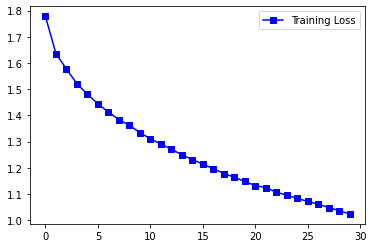

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list,'s-',color = 'blue', label="Training Loss")

plt.legend()
plt.show()
plt.savefig("training-loss.jpg") 

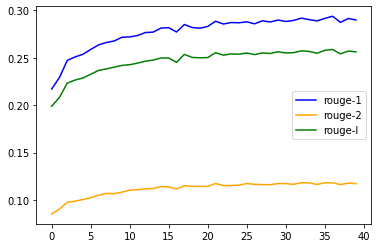

<Figure size 432x288 with 0 Axes>

In [31]:
plt.plot([rouge ['rouge-1']['f'] for rouge in val_rouge_list], label = "rouge-1", color = 'blue')
plt.plot([rouge ['rouge-2']['f'] for rouge in val_rouge_list], label = "rouge-2", color = 'orange')
plt.plot([rouge ['rouge-l']['f'] for rouge in val_rouge_list], label = "rouge-l", color = 'green')

plt.legend()
plt.show()
plt.savefig("rouge-score.jpg") 

In [1]:
model.eval()
label_list, eval_predictions = [],[]
with torch.no_grad():
    for input_ids, labels in validloader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        outputs = model.generate(input_ids, num_beams=5, max_length=64)
        eval_predictions += outputs
        label_list+=labels
    rouge = compute_metrics(eval_predictions, label_list)

NameError: name 'model' is not defined

model.eval()
label_list, eval_predictions = [],[]
with torch.no_grad():
    for input_ids, labels in validloader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        outputs = model.generate(input_ids, num_beams=1, max_length=64)
        eval_predictions += outputs
        label_list+=labels
    rouge = compute_metrics(eval_predictions, label_list)